# Midterm

## Starter Code
packages: cycler joblib kiwisolver matplotlib numpy pandas Pillow pyparsing python-dateutil pytz
scikit-learn
scipy
seaborn
six
sklearn
threadpoolctl

In [1]:
# Import Packages

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#run jupyter notebook
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10

train.csv shape is  (1697533, 9)
test.csv shape is  (300000, 2)

   Id   ProductId          UserId  HelpfulnessNumerator  \
0   0  0005019281   ADZPIG9QOCDG5                     0   
1   1  0005019281  A35947ZP82G7JH                     0   
2   2  0005019281  A3UORV8A9D5L2E                     0   
3   3  0005019281  A1VKW06X1O2X7V                     0   
4   4  0005019281  A3R27T4HADWFFJ                     0   

   HelpfulnessDenominator  Score        Time  \
0                       0    4.0  1203984000   
1                       0    3.0  1388361600   
2                       0    3.0  1388361600   
3                       0    5.0  1202860800   
4                       0    4.0  1387670400   

                                        Summary  \
0                     good version of a classic   
1                        Good but not as moving   
2         Winkler's Performance was ok at best!   
3  It's an enjoyable twist on the classic story   
4                              Best 

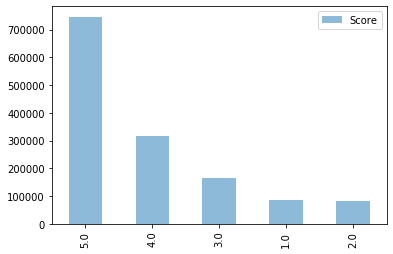

In [46]:
#initial-exploration.py

trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

In [47]:
#generate-Xtrain-Xsubmission.py

X_test = pd.merge(trainingSet, testingSet, left_on='Id', right_on='Id')
print(X_test.columns)

X_test = X_test.drop(columns=['Score_x'])
X_test = X_test.rename(columns={'Score_y': 'Score'})

print(X_test.columns)
X_test.to_csv("X_submission.csv", index=False)

X_train = trainingSet[trainingSet['Score'].notnull()]

print(trainingSet.shape)
print(X_train.shape)
X_train.to_csv("X_train.csv", index=False)

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score_x', 'Time', 'Summary', 'Text',
       'Score_y'],
      dtype='object')
Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')
(1697533, 9)
(1397533, 9)


## 1. Constant Score Prediction
to the file sumbission_constant.csv

In [14]:
#predict-constant.py

prediction = pd.read_csv("X_submission.csv")
prediction['Score'] = 4.0

submission = prediction[['Id', 'Score']]
print(submission.head())
submission.to_csv("submission_constant.csv", index=False)

   Id  Score
0   5    4.0
1  11    4.0
2  17    4.0
3  46    4.0
4  47    4.0


## 2. Score Predition using KNN 3 clusters
to the file submission_knn.csv

RMSE on testing set =  2.50974572390264


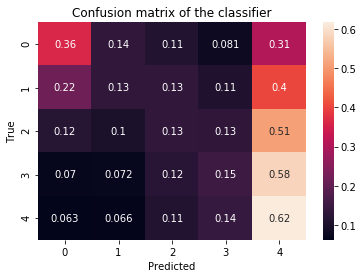

In [15]:
#predict-knn.py

# Load files into DataFrames
X_train = pd.read_csv("X_train.csv")
X_submission = pd.read_csv("X_submission.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# Process the DataFrames
# This is where you can do more feature extraction
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_processed, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_processed)
X_submission['Score'] = model.predict(X_submission_processed)

# Evaluate your model on the testing set
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create the submission file
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission_knn.csv", index=False)

## 3. Score Prediction using Random Forest
to the file submission_rf.csv

In [ ]:
#load data
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

In [ ]:
#add more features

#1. add average user score and average product score
#1.1 user average score
train_user = pd.DataFrame(trainingSet[['UserId','Score']])
train_user_av = train_user.groupby(['UserId']).mean().round(0)
train_user_avscore = train_user_av.rename(columns = {"Score":"User_average"})

result = pd.merge(trainingSet, train_user_avscore, how="left",on="UserId")

#1.2 product average score
train_product = pd.DataFrame(trainingSet[['ProductId','Score']])
train_product_av = train_product.groupby(['ProductId']).mean().round(0)
train_product_avscore = train_product_av.rename(columns = {"Score":"Product_average"})

trainingSet = pd.merge(result, X_train_product_avscore, how="left",on="ProductId")
print("finish user average and product average")

#2. add lemma review
#clean words with stopwords and delete all not words and tokenize
#lemmatization
STOPWORDS = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    textblob = TextBlob(text)
    textblob.correct()
    text = re.sub(r'[^a-zA-Z]', ' ', str(textblob))
    words = text.lower().split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in STOPWORDS]
    return ' '.join(words)

trainingSet['lemma_review'] = traningSet.Text.apply(lemmatization)
trainingSet['lemma_sum'] = traningSet.Summary.apply(lemmatization)
print("finish lemma review and summary on training set")

#3. add polarity
#do sentiment test
def sentiment(text):
    textblob = TextBlob(text)
    return textblob.polarity    

trainingSet['Polarity_review'] = trainingSet.lemma_review.apply(sentiment)
trainingSet['Polarity_sum'] = trainingSet.lemma_sum.apply(sentiment)
print("finish polarity of review and summary on training set")


In [ ]:
#create x_text and x_train
X_test = pd.merge(trainingSet, testingSet, left_on='Id', right_on='Id')

X_test = X_test.drop(columns=['Score_x'])
X_test = X_test.rename(columns={'Score_y': 'Score'})

X_test.to_csv("X_submission.csv", index=False)

X_train = trainingSet[trainingSet['Score'].notnull()]

X_train.to_csv("X_train.csv", index=False)

In [ ]:
# Load files into DataFrames
X_train = pd.read_csv("X_train.csv")
X_submission = pd.read_csv("X_submission.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

#4. vecotorize lemma review and summary
#vectorize train set on review
vectorizer_review = CountVectorizer(max_features = 5000) 
vector_review = vectorizer_review.fit_transform(X_train.lemma_review)

#from occurance to frequencies
tfidf_transformer_review = TfidfTransformer()
train_tfidf_review = tfidf_transformer_review.fit_transform(vector_review)

#vectorize test set on test review
test_vector_review = vectorizer_review.fit(X_test.lemma_review)

#from occurance to frequencies
test_tfidf_review = tfidf_transformer_review.fit(test_vector_review)

#vectorize submission set on test review
sub_vector_review = vectorizer_review.fit(X_submission.lemma_review)

#from occurance to frequencies
sub_tfidf_review = tfidf_transformer_review.fit(sub_vector_review)

print("finish tfidf on review and summary of training set")

# Process the DataFrames
# This is where you can do more feature extraction
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'lemma_review','lemma_sum'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary','lemma_review','lemma_sum'])
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score','lemma_review','lemma_sum'])

# Learn the review model
#create random forest model
forest_review = RandomForestClassifier(n_estimators = 100)
model_review = forest_review.fit(train_tfidf_review, Y_train)
print("finish review fit")

# Learn the model
#create random forest model
forest = RandomForestClassifier(n_estimators = 100)
model = forest.fit(X_train_processed, Y_train)
print("finish fit")

# Predict based on review
Y_test_review_pre = model_review.predict(test_tfidf_review)
X_submission['Score1'] = model_review.predict(sub_tfidf_review)

# Predict the score using the model
Y_test_regular_pre = model.predict(X_test_processed)
X_submission['Score2'] = model.predict(X_submission_processed)

Y_av = (Y_test_review_pre * 0.5 + Y_test_regular_pre * 0.5).round(0)
X_submission['Score']=(X_submission['Score1']*0.5+X_submission['Score2']*0.5).round(0)

# Evaluate your model on the testing set
print("RMSE on testing set: review predict = ", mean_squared_error(Y_test, Y_test_review_pre))
print("RMSE on testing set: regular predict = ", mean_squared_error(Y_test, Y_test_regular_pre))
print("RMSE on testing set: regular predict = ", mean_squared_error(Y_test, Y_av))

# Plot a confusion matrix
cm1 = confusion_matrix(Y_test, Y_test_review_pre, normalize='true')
print(cm1)
cm2 = confusion_matrix(Y_test, Y_test_regular_pre, normalize='true')
print(cm2)
#sns.heatmap(cm, annot=True)
#plt.title('Confusion matrix of the classifier')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Create the submission file
#submission = X_submission[['Id', 'Score']]
#submission.to_csv("submission.csv", index=False)

In [17]:
#create naive bayes model
#clf = MultinomialNB().fit(X_train['tfidf'], Y_train)
#print("finish fit")

(786111, 1000)
finish fit


In [ ]:
#use naive bayes modal to predict
#X_submission['NB_Score'] = clf.predict(submission_data_features)